# Qwen3 Model Comparison: 1.7B vs 4B vs 14B

## Overview
This notebook compares the performance of different Qwen3 model sizes (1.7B, 4B, and 14B parameters) on entity and relationship extraction tasks for threat intelligence.

### Task Description
- **Input**: Threat intelligence text content
- **Output**: Named entities and relationships in structured format
- **Models**: Qwen3-1.7B, Qwen3-4B, Qwen3-14B (reference)
- **Metrics**: F1-score, Recall, Accuracy

### Reference Data
- Qwen3-14B results: `data/entity-extraction/Qwen3-14B_2025-08-23_10-14-28_0_427.json`
- Based on methodology from `03_entity_relationship_extraction.ipynb`


## 1. Setup and Imports


In [1]:
import json
import os
import re
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional
from collections import defaultdict, Counter
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
import numpy as np

# Load environment and model setup
from dotenv import load_dotenv
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Load environment variables
load_dotenv()

print("🔧 Setting up Qwen3 Model Comparison Pipeline")
print("=" * 60)


🔧 Setting up Qwen3 Model Comparison Pipeline


## 2. Device and Configuration Setup


In [2]:
# Device setup
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

print(f"🖥️  Using device: {device.upper()}")
print(f"🔧 PyTorch version: {torch.__version__}")

# Memory cleanup
if device == "cuda":
    torch.cuda.empty_cache()
elif device == "mps":
    import gc
    gc.collect()
    if hasattr(torch.mps, 'empty_cache'):
        torch.mps.empty_cache()

# Model configurations
MODELS_CONFIG = {
    "qwen3-1.7b": {
        "name": "unsloth/Qwen3-1.7B",
        "display_name": "Qwen3 1.7B",
    },
    "qwen3-4b": {
        "name": "unsloth/Qwen3-4B",
        "display_name": "Qwen3 4B",
    },
    "qwen3-14b": {
        "name": "unsloth/Qwen3-14B",
        "display_name": "Qwen3 14B",
    }
}

from google.colab import userdata
# Get HF token from environment
HF_TOKEN = userdata.get('HF_TOKEN')
print(f"🔑 HuggingFace Token: {'✅ Found' if HF_TOKEN else '❌ Missing'}")


🖥️  Using device: CUDA
🔧 PyTorch version: 2.8.0+cu126
🔑 HuggingFace Token: ✅ Found


## 3. Data Loading Functions


In [3]:
from google.colab import drive
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/LLM_TKIG/'

Mounted at /content/drive


In [4]:
def load_threat_intelligence_data(input_file: str) -> list:
    """
    Load threat intelligence data from JSON file.
    """
    try:
        with open(input_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"✅ Loaded {len(data)} records from {input_file}")
        return data
    except Exception as e:
        print(f"❌ Error loading {input_file}: {e}")
        return []

def load_reference_results(reference_file: str) -> list:
    """
    Load reference results from Qwen3-14B extraction.
    """
    try:
        with open(reference_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"✅ Loaded {len(data)} reference results from {reference_file}")
        return data
    except Exception as e:
        print(f"❌ Error loading reference file {reference_file}: {e}")
        return []

# Load data
data_path = f'{BASE_PATH}/data/processed/merged_threat_intelligence.json'
reference_path = f'{BASE_PATH}/data/entity-extraction/Qwen3-14B_2025-08-23_10-14-28_0_427.json'

threat_intel_data = load_threat_intelligence_data(data_path)
reference_results = load_reference_results(reference_path)

if threat_intel_data:
    print(f"\n📊 Sample data structure:")
    print(f"   Keys: {list(threat_intel_data[0].keys())}")
    print(f"   Title: {threat_intel_data[0]['title'][:100]}...")

if reference_results:
    print(f"\n📊 Reference results structure:")
    print(f"   Keys: {list(reference_results[0].keys())}")
    print(f"   Entities: {reference_results[0].get('entity_count', 0)}")
    print(f"   Relationships: {reference_results[0].get('relationship_count', 0)}")


✅ Loaded 427 records from /content/drive/MyDrive/LLM_TKIG//data/processed/merged_threat_intelligence.json
✅ Loaded 427 reference results from /content/drive/MyDrive/LLM_TKIG//data/entity-extraction/Qwen3-14B_2025-08-23_10-14-28_0_427.json

📊 Sample data structure:
   Keys: ['title', 'content', 'link']
   Title: FortiGuard Labs Threat Research...

📊 Reference results structure:
   Keys: ['title', 'link', 'content', 'extraction', 'entity_count', 'relationship_count']
   Entities: 15
   Relationships: 10


## 4. Model Loading Functions


In [5]:
def setup_qwen3_model(model_key: str, hf_token: str = None) -> Optional[Any]:
    """
    Load Qwen3 model with proper configuration based on model size.
    """
    if model_key not in MODELS_CONFIG:
        print(f"❌ Unknown model key: {model_key}")
        return None

    config = MODELS_CONFIG[model_key]
    model_name = config["name"]
    display_name = config["display_name"]
    hf_token = hf_token or HF_TOKEN

    print(f"🤖 Loading {display_name} ({model_name})")
    print(f"📱 Device: {device.upper()}")
    print(f"🔑 Token: {'✅ Found' if hf_token else '❌ Missing'}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            token=hf_token,
            trust_remote_code=True
        )
        tokenizer.pad_token = tokenizer.pad_token or tokenizer.eos_token

        # Configure model loading based on device and model size
        torch_dtype = torch.float16 if device == "cuda" else torch.float32
        device_map = "auto" if device == "cuda" else None

        # Load model
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            token=hf_token,
            trust_remote_code=True,
            torch_dtype=torch_dtype,
            device_map=device_map,
            use_cache=False,
            low_cpu_mem_usage=True
        )

        # Move to device if not using device_map
        if device_map is None and device in ["mps", "cuda"]:
            model.to(device)

        # Create pipeline
        if device_map is None:
            pipe = pipeline(
                "text-generation",
                model=model,
                tokenizer=tokenizer,
                device=0 if device != "cpu" else -1,
                torch_dtype=torch_dtype,
                model_kwargs={"use_cache": False}
            )
        else:
            pipe = pipeline(
                "text-generation",
                model=model,
                tokenizer=tokenizer,
                torch_dtype=torch_dtype,
                model_kwargs={"use_cache": False}
            )

        print(f"✅ Successfully loaded {display_name} on {device.upper()}")
        return pipe

    except Exception as e:
        print(f"❌ Error loading {display_name}: {e}")
        return None

def cleanup_model(pipe):
    """
    Clean up model resources.
    """
    if pipe is not None:
        del pipe
        if device == "cuda":
            torch.cuda.empty_cache()
        elif device == "mps":
            import gc
            gc.collect()
            if hasattr(torch.mps, 'empty_cache'):
                torch.mps.empty_cache()


## 5. Entity Extraction Functions (from Notebook 03)


In [6]:
def create_entity_extraction_prompt(text: str) -> str:
    """
    Create prompt for entity and relationship extraction focusing on core cybersecurity entity types.
    """
    # Truncate text to avoid token limits
    text_truncated = (text[:1500] if text else "").replace('\n', ' ').strip()

    prompt = f"""Instruction: Please identify the following types of entities and then extract the relationships between these extracted entities:

Entity Types (focus on these only):
- Malware: Malicious software (e.g., 'Stuxnet', 'Emotet', 'Backdoor.Atharvan')
- Threat Type: Category of threats (e.g., 'Ransomware', 'APT', 'Botnet')
- Attacker: Threat actors/groups (e.g., 'APT28', 'Lazarus Group', 'Shuckworm')
- Technique: Attack techniques/TTPs (e.g., 'T1057: Process Discovery', 'Privilege Escalation', 'Phishing')
- Tool: Security tools or attack tools (e.g., 'PowerShell', 'Cobalt Strike', 'EHole')
- Vulnerability: Security weaknesses (e.g., 'CVE-2020-1472', 'CVE-2021-44228')
- IP: IP addresses (e.g., '45.153.243.93', '192.168.1.100')
- Domain: Domain names (e.g., 'malicious-domain[.]com', 'evil[.]example[.]com')
- URL: URLs (e.g., 'hxxp://178.73.192[.]15/cal.exe')
- File: File names (e.g., 'rtk.lnk', 'payload.exe', 'shtasks.exe')
- Hash: File hashes (e.g., '2aee8bb2a953124803bc42e5c42935c9', MD5/SHA1/SHA256)

Relationship Types:
- use, hash, aka, execute, used by, download, resolved to, IP, drop, associated with, deploy, communicate with, connect to, install, exploit, contain, run, launch, target, linked to

If there are no entities and relationships pertaining to the specified types, please state 'No related entities and relations'. Make sure to follow the output format shown in the following examples.

Example 1:
Input: A hitherto unknown attack group has been observed targeting a materials research organization in Asia. The group, which Symantec calls Clasiopa, is characterized by a distinct toolset, which includes one piece of custom malware (Backdoor.Atharvan).
Output: Named Entities: (Clasiopa, Attacker), (Backdoor.Atharvan, Malware)\nRelationships: (Clasiopa, uses, Backdoor.Atharvan)

Example 2:
Input: The Emotet malware has been observed using new phishing techniques to target banking institutions. The malware exploits CVE-2021-1234 vulnerability in Microsoft Office.
Output: Named Entities: (Emotet, Malware), (phishing, Technique), (CVE-2021-1234, Vulnerability), (Microsoft Office, Tool)\nRelationships: (Emotet, uses, phishing), (Emotet, exploits, CVE-2021-1234)

Example 3:
Input: The threat actor downloaded malicious payload from hxxp://malicious-domain[.]com/payload.exe and used hash 2aee8bb2a953124803bc42e5c42935c9 to verify file integrity. The attack targeted IP address 192.168.1.100.
Output: Named Entities: (threat actor, Attacker), (malicious payload, File), (hxxp://malicious-domain[.]com/payload.exe, URL), (2aee8bb2a953124803bc42e5c42935c9, Hash), (192.168.1.100, IP)\nRelationships: (threat actor, uses, hxxp://malicious-domain[.]com/payload.exe), (threat actor, targets, 192.168.1.100)

Example 4:
Input: H2Miner botnet uses Kinsing malware and Cobalt Strike to deploy XMRig miners. The campaign communicates with C2 server at evil[.]domain[.]com and is attributed to APT group.
Output: Named Entities: (H2Miner, Threat Type), (Kinsing, Malware), (Cobalt Strike, Tool), (XMRig, Tool), (evil[.]domain[.]com, Domain), (APT group, Attacker)\nRelationships: (H2Miner, uses, Kinsing), (H2Miner, uses, Cobalt Strike), (H2Miner, uses, XMRig), (Kinsing, communicatesWith, evil[.]domain[.]com), (H2Miner, attributedTo, APT group)

Example 5:
Input: The weather forecast shows sunny skies and moderate temperatures for the weekend.
Output: No related entities and relations

Now extract entities and relationships from the following text:
Input: {text_truncated}
Output:"""

    return prompt

def extract_tuples_from_text(text: str) -> List[Tuple]:
    """
    Extract tuples from text using regex pattern matching.
    """
    tuples = []

    # Pattern to match (item1, item2) or (item1, item2, item3)
    pattern = r'\(([^)]+)\)'
    matches = re.findall(pattern, text)

    for match in matches:
        # Split by comma and clean up
        parts = [part.strip() for part in match.split(',')]
        if len(parts) >= 2:
            tuples.append(tuple(parts))

    return tuples

def parse_extraction_output(output: str) -> Tuple[List[Tuple], List[Tuple]]:
    """
    Parse the model output to extract entities and relationships.
    """
    entities = []
    relationships = []

    # Check for "No related entities" case
    if "no related entities" in output.lower():
        return entities, relationships

    try:
        # Split output into lines
        lines = [line.strip() for line in output.split('\n') if line.strip()]

        current_section = None
        for line in lines:
            line_lower = line.lower()

            if "named entities:" in line_lower:
                current_section = "entities"
                # Extract entities from the same line
                entity_part = line.split(":", 1)[1] if ":" in line else ""
                entities.extend(extract_tuples_from_text(entity_part))

            elif "relationships:" in line_lower:
                current_section = "relationships"
                # Extract relationships from the same line
                rel_part = line.split(":", 1)[1] if ":" in line else ""
                relationships.extend(extract_tuples_from_text(rel_part))

            elif current_section == "entities":
                entities.extend(extract_tuples_from_text(line))

            elif current_section == "relationships":
                relationships.extend(extract_tuples_from_text(line))

    except Exception as e:
        print(f"⚠️  Error parsing output: {e}")

    return entities, relationships

def extract_entities_and_relationships(pipe, text: str) -> Dict[str, Any]:
    """
    Extract entities and relationships from text using the LLM.
    """
    try:
        prompt = create_entity_extraction_prompt(text)

        # Generate response
        response = pipe(
            prompt,
            max_new_tokens=300,
            do_sample=False,
            temperature=0.1,
            pad_token_id=pipe.tokenizer.eos_token_id,
        )

        # Extract generated text
        generated_text = response[0]['generated_text']
        answer = generated_text[len(prompt):].strip()

        # Parse the response
        entities, relationships = parse_extraction_output(answer)

        return {
            "raw_output": answer,
            "entities": entities,
            "relationships": relationships,
            "has_entities": len(entities) > 0
        }

    except Exception as e:
        print(f"❌ Error in extraction: {e}")
        return {
            "raw_output": "",
            "entities": [],
            "relationships": [],
            "has_entities": False,
            "error": str(e)
        }


## 6. Batch Processing Functions


In [7]:
def process_batch_extraction(data: List[Dict], pipe, model_name: str,
                           start: int = 0, batch_size: int = 30) -> List[Dict]:
    """
    Process a batch of articles for entity and relationship extraction.
    """
    end = min(start + batch_size, len(data))
    articles_to_process = data[start:end]
    results = []

    print(f"🔍 Processing {len(articles_to_process)} articles with {model_name}...")
    print(f"📊 Range: {start} to {end-1}")

    for i, article in enumerate(articles_to_process):
        try:
            title = article.get('title', '')
            content = article.get('content', '')
            link = article.get('link', '')

            print(f"\\n  Processing {i+1}/{len(articles_to_process)}: {title[:60]}...")

            # Extract entities and relationships
            extraction_result = extract_entities_and_relationships(pipe, content)
            entities = extraction_result.get('entities', [])
            relationships = extraction_result.get('relationships', [])

            # Create result record
            result = {
                "title": title,
                "link": link,
                "content": content,
                "extraction": extraction_result,
                "entity_count": len(entities),
                "relationship_count": len(relationships),
                "model": model_name,
                "index": start + i
            }

            results.append(result)

            # Progress update
            if (i + 1) % 10 == 0:
                print(f"    ✅ Processed {i+1}/{len(articles_to_process)} articles")

        except Exception as e:
            print(f"    ❌ Error processing article {i+1}: {e}")
            # Add error record
            result = {
                "title": article.get('title', ''),
                "link": article.get('link', ''),
                "content": article.get('content', ''),
                "extraction": {"error": str(e)},
                "entity_count": 0,
                "relationship_count": 0,
                "model": model_name,
                "index": start + i
            }
            results.append(result)

    print(f"\\n💾 Completed batch processing: {len(results)} results")
    return results

def save_results(results: List[Dict], output_path: str):
    """
    Save extraction results to JSON file.
    """
    try:
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(results, f, ensure_ascii=False, indent=2)
        print(f"💾 Saved {len(results)} results to {output_path}")
    except Exception as e:
        print(f"❌ Error saving results: {e}")


## 7. Evaluation Metrics Functions


In [8]:
def normalize_entity(entity: Tuple[str, str]) -> Tuple[str, str]:
    """
    Normalize entity for comparison (lowercase, strip whitespace).
    """
    return (entity[0].lower().strip(), entity[1].lower().strip())

def normalize_relationship(rel: Tuple[str, str, str]) -> Tuple[str, str, str]:
    """
    Normalize relationship for comparison.
    """
    return (rel[0].lower().strip(), rel[1].lower().strip(), rel[2].lower().strip())

def extract_entities_relationships_from_result(result: Dict) -> Tuple[List[Tuple], List[Tuple]]:
    """
    Extract normalized entities and relationships from a result record.
    """
    extraction = result.get('extraction', {})

    # Get entities
    entities = extraction.get('entities', [])
    normalized_entities = []
    for entity in entities:
        if isinstance(entity, (list, tuple)) and len(entity) >= 2:
            normalized_entities.append(normalize_entity((entity[0], entity[1])))

    # Get relationships
    relationships = extraction.get('relationships', [])
    normalized_relationships = []
    for rel in relationships:
        if isinstance(rel, (list, tuple)) and len(rel) >= 3:
            normalized_relationships.append(normalize_relationship((rel[0], rel[1], rel[2])))

    return normalized_entities, normalized_relationships

def calculate_metrics_for_pair(reference_results: List[Dict],
                              test_results: List[Dict]) -> Dict[str, float]:
    """
    Calculate F1, Precision, Recall for entities and relationships between two result sets.
    """
    # Align results by index or title
    ref_dict = {}
    test_dict = {}

    # Create dictionaries keyed by title for alignment
    for result in reference_results:
        title = result.get('title', '').strip()
        if title:
            ref_dict[title] = result

    for result in test_results:
        title = result.get('title', '').strip()
        if title:
            test_dict[title] = result

    # Find common articles
    common_titles = set(ref_dict.keys()) & set(test_dict.keys())
    print(f"📊 Comparing {len(common_titles)} common articles")

    if len(common_titles) == 0:
        print("⚠️  No common articles found for comparison")
        return {
            'entity_precision': 0.0, 'entity_recall': 0.0, 'entity_f1': 0.0,
            'relationship_precision': 0.0, 'relationship_recall': 0.0, 'relationship_f1': 0.0,
            'overall_precision': 0.0, 'overall_recall': 0.0, 'overall_f1': 0.0,
            'common_articles': 0
        }

    # Collect all entities and relationships
    ref_entities_all = set()
    test_entities_all = set()
    ref_relationships_all = set()
    test_relationships_all = set()

    for title in common_titles:
        # Reference data
        ref_entities, ref_relationships = extract_entities_relationships_from_result(ref_dict[title])
        ref_entities_all.update(ref_entities)
        ref_relationships_all.update(ref_relationships)

        # Test data
        test_entities, test_relationships = extract_entities_relationships_from_result(test_dict[title])
        test_entities_all.update(test_entities)
        test_relationships_all.update(test_relationships)

    # Calculate entity metrics
    entity_intersection = ref_entities_all & test_entities_all
    entity_precision = len(entity_intersection) / len(test_entities_all) if test_entities_all else 0.0
    entity_recall = len(entity_intersection) / len(ref_entities_all) if ref_entities_all else 0.0
    entity_f1 = 2 * entity_precision * entity_recall / (entity_precision + entity_recall) if (entity_precision + entity_recall) > 0 else 0.0

    # Calculate relationship metrics
    rel_intersection = ref_relationships_all & test_relationships_all
    rel_precision = len(rel_intersection) / len(test_relationships_all) if test_relationships_all else 0.0
    rel_recall = len(rel_intersection) / len(ref_relationships_all) if ref_relationships_all else 0.0
    rel_f1 = 2 * rel_precision * rel_recall / (rel_precision + rel_recall) if (rel_precision + rel_recall) > 0 else 0.0

    # Calculate overall metrics (entities + relationships combined)
    all_ref = ref_entities_all | ref_relationships_all
    all_test = test_entities_all | test_relationships_all
    all_intersection = entity_intersection | rel_intersection

    overall_precision = len(all_intersection) / len(all_test) if all_test else 0.0
    overall_recall = len(all_intersection) / len(all_ref) if all_ref else 0.0
    overall_f1 = 2 * overall_precision * overall_recall / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0

    return {
        'entity_precision': entity_precision,
        'entity_recall': entity_recall,
        'entity_f1': entity_f1,
        'relationship_precision': rel_precision,
        'relationship_recall': rel_recall,
        'relationship_f1': rel_f1,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'common_articles': len(common_titles),
        'ref_entities_count': len(ref_entities_all),
        'test_entities_count': len(test_entities_all),
        'ref_relationships_count': len(ref_relationships_all),
        'test_relationships_count': len(test_relationships_all)
    }


## 8. Model Comparison Execution


In [9]:
# Configuration for comparison
BATCH_SIZE = 30  # Adjust based on available memory
START_INDEX = 0
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Storage for results
model_results = {}
model_metrics = {}

# Update MODELS_CONFIG to include fine-tuned model
MODELS_CONFIG.update({
    "qwen3-1.7b-finetuned": {
        "name": "Fine-tuned Qwen3 1.7B",
        "display_name": "Qwen3 1.7B Fine-tuned",
    }
})

# Models to test (including fine-tuned model)
models_to_test = ['qwen3-1.7b', 'qwen3-1.7b-finetuned', 'qwen3-4b']

print(f"🚀 Starting model comparison with {len(models_to_test)} models")
print(f"📊 Batch size: {BATCH_SIZE}")
print(f"📅 Timestamp: {timestamp}")
print(f"🔬 Models: {[MODELS_CONFIG[k]['display_name'] for k in models_to_test]}")
print("=" * 60)


🚀 Starting model comparison with 3 models
📊 Batch size: 30
📅 Timestamp: 2025-08-24_12-35-10
🔬 Models: ['Qwen3 1.7B', 'Qwen3 1.7B Fine-tuned', 'Qwen3 4B']


### 8.1 Test Qwen3 1.7B Model


In [10]:
# Test Qwen3 1.7B
model_key = 'qwen3-1.7b'
print(f"\\n🔥 Testing {MODELS_CONFIG[model_key]['display_name']}")
print("=" * 40)

pipe_1_7b = setup_qwen3_model(model_key)

if pipe_1_7b:
    # Run extraction
    results_1_7b = process_batch_extraction(
        threat_intel_data,
        pipe_1_7b,
        MODELS_CONFIG[model_key]['display_name'],
        start=START_INDEX,
        batch_size=BATCH_SIZE
    )

    # Save results
    output_path_1_7b = f"{BASE_PATH}/data/entity-extraction/Qwen3-1.7B_{timestamp}_{START_INDEX}_{START_INDEX + BATCH_SIZE}.json"
    save_results(results_1_7b, output_path_1_7b)
    model_results[model_key] = results_1_7b

    # Cleanup
    cleanup_model(pipe_1_7b)

    print(f"✅ Completed {MODELS_CONFIG[model_key]['display_name']} extraction")
else:
    print(f"❌ Failed to load {MODELS_CONFIG[model_key]['display_name']}")


\n🔥 Testing Qwen3 1.7B
🤖 Loading Qwen3 1.7B (unsloth/Qwen3-1.7B)
📱 Device: CUDA
🔑 Token: ✅ Found


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Successfully loaded Qwen3 1.7B on CUDA
🔍 Processing 30 articles with Qwen3 1.7B...
📊 Range: 0 to 29
\n  Processing 1/30: FortiGuard Labs Threat Research...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 2/30: NailaoLocker Ransomware’s “Cheese”...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 3/30: Improving Cloud Intrusion Detection and Triage with FortiCNA...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 4/30: Old Miner, New Tricks...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 5/30: How FortiSandbox 5.0 Detects Dark 101 Ransomware Despite Eva...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 6/30: Catching Smarter Mice with Even Smarter Cats...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 7/30: NordDragonScan: Quiet Data-Harvester on Windows...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 8/30: RondoDox Unveiled: Breaking Down a New Botnet Threat...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 9/30: DCRAT Impersonating the Colombian Government...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 10/30: Dissecting a Malicious Havoc Sample...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


    ✅ Processed 10/30 articles
\n  Processing 11/30: Threat Group Targets Companies in Taiwan...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 12/30: RolandSkimmer: Silent Credit Card Thief Uncovered...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 13/30: How a Malicious Excel File (CVE-2017-0199) Delivers the Form...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 14/30: Deep Dive into a Dumped Malware without a PE Header...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 15/30: Infostealer Malware FormBook Spread via Phishing Campaign – ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 16/30: Ransomware Roundup – VanHelsing...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 17/30: Horabot Unleashed: A Stealthy Phishing Threat...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 18/30: Multilayered Email Attack: How a PDF Invoice and Geo-Fencing...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 19/30: FortiGuard Incident Response Team Detects Intrusion into Mid...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 20/30: Key Takeaways from the 2025 Global Threat Landscape Report...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


    ✅ Processed 20/30 articles
\n  Processing 21/30: IngressNightmare: Understanding CVE‑2025‑1974 in Kubernetes ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 22/30: Infostealer Malware FormBook Spread via Phishing Campaign – ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 23/30: New Rust Botnet "RustoBot" is Routed via Routers...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 24/30: Malicious NPM Packages Targeting PayPal Users...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 25/30: Real-Time Anti-Phishing: Essential Defense Against Evolving ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 26/30: Fortinet Identifies Malicious Packages in the Wild: Insights...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 27/30: Havoc: SharePoint with Microsoft Graph API turns into FUD C2...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 28/30: Winos 4.0 Spreads via Impersonation of Official Email to Tar...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 29/30: FortiSandbox 5.0 Detects Evolving Snake Keylogger Variant...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 30/30: Ransomware Roundup – Lynx...
    ✅ Processed 30/30 articles
\n💾 Completed batch processing: 30 results
💾 Saved 30 results to /content/drive/MyDrive/LLM_TKIG//data/entity-extraction/Qwen3-1.7B_2025-08-24_12-35-10_0_30.json
✅ Completed Qwen3 1.7B extraction


### 8.2 Test Qwen3 4B Model


In [11]:
# Test Qwen3 4B
model_key = 'qwen3-4b'
print(f"\\n🔥 Testing {MODELS_CONFIG[model_key]['display_name']}")
print("=" * 40)

pipe_4b = setup_qwen3_model(model_key)

if pipe_4b:
    # Run extraction
    results_4b = process_batch_extraction(
        threat_intel_data,
        pipe_4b,
        MODELS_CONFIG[model_key]['display_name'],
        start=START_INDEX,
        batch_size=BATCH_SIZE
    )

    # Save results
    output_path_4b = f"{BASE_PATH}/data/entity-extraction/Qwen3-4B_{timestamp}_{START_INDEX}_{START_INDEX + BATCH_SIZE}.json"
    save_results(results_4b, output_path_4b)
    model_results[model_key] = results_4b

    # Cleanup
    cleanup_model(pipe_4b)

    print(f"✅ Completed {MODELS_CONFIG[model_key]['display_name']} extraction")
else:
    print(f"❌ Failed to load {MODELS_CONFIG[model_key]['display_name']}")


\n🔥 Testing Qwen3 4B
🤖 Loading Qwen3 4B (unsloth/Qwen3-4B)
📱 Device: CUDA
🔑 Token: ✅ Found


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Successfully loaded Qwen3 4B on CUDA
🔍 Processing 30 articles with Qwen3 4B...
📊 Range: 0 to 29
\n  Processing 1/30: FortiGuard Labs Threat Research...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 2/30: NailaoLocker Ransomware’s “Cheese”...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 3/30: Improving Cloud Intrusion Detection and Triage with FortiCNA...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 4/30: Old Miner, New Tricks...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 5/30: How FortiSandbox 5.0 Detects Dark 101 Ransomware Despite Eva...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 6/30: Catching Smarter Mice with Even Smarter Cats...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 7/30: NordDragonScan: Quiet Data-Harvester on Windows...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 8/30: RondoDox Unveiled: Breaking Down a New Botnet Threat...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 9/30: DCRAT Impersonating the Colombian Government...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 10/30: Dissecting a Malicious Havoc Sample...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


    ✅ Processed 10/30 articles
\n  Processing 11/30: Threat Group Targets Companies in Taiwan...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 12/30: RolandSkimmer: Silent Credit Card Thief Uncovered...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 13/30: How a Malicious Excel File (CVE-2017-0199) Delivers the Form...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 14/30: Deep Dive into a Dumped Malware without a PE Header...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 15/30: Infostealer Malware FormBook Spread via Phishing Campaign – ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 16/30: Ransomware Roundup – VanHelsing...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 17/30: Horabot Unleashed: A Stealthy Phishing Threat...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 18/30: Multilayered Email Attack: How a PDF Invoice and Geo-Fencing...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 19/30: FortiGuard Incident Response Team Detects Intrusion into Mid...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 20/30: Key Takeaways from the 2025 Global Threat Landscape Report...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


    ✅ Processed 20/30 articles
\n  Processing 21/30: IngressNightmare: Understanding CVE‑2025‑1974 in Kubernetes ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 22/30: Infostealer Malware FormBook Spread via Phishing Campaign – ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 23/30: New Rust Botnet "RustoBot" is Routed via Routers...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 24/30: Malicious NPM Packages Targeting PayPal Users...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 25/30: Real-Time Anti-Phishing: Essential Defense Against Evolving ...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 26/30: Fortinet Identifies Malicious Packages in the Wild: Insights...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 27/30: Havoc: SharePoint with Microsoft Graph API turns into FUD C2...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 28/30: Winos 4.0 Spreads via Impersonation of Official Email to Tar...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 29/30: FortiSandbox 5.0 Detects Evolving Snake Keylogger Variant...


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


\n  Processing 30/30: Ransomware Roundup – Lynx...
    ✅ Processed 30/30 articles
\n💾 Completed batch processing: 30 results
💾 Saved 30 results to /content/drive/MyDrive/LLM_TKIG//data/entity-extraction/Qwen3-4B_2025-08-24_12-35-10_0_30.json
✅ Completed Qwen3 4B extraction


## 8.3 Fine-tune Qwen3 1.7B with Unsloth

Before comparing models, we'll fine-tune Qwen3 1.7B using Unsloth for better performance on entity extraction tasks.


In [ ]:
# %%capture
# import os
# if "COLAB_" not in "".join(os.environ.keys()):
#     !pip install unsloth
# else:
#     !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
#     !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
#     !pip install --no-deps unsloth



### 8.3.1 Prepare Training Data


In [12]:
def prepare_training_data_from_reference(reference_data: List[Dict], max_samples: int = 100) -> List[Dict]:
    """
    Prepare training data from Qwen3 14B reference results for fine-tuning.
    """
    training_data = []

    print(f"🔄 Preparing training data from {len(reference_data)} reference samples...")

    # Use a subset for training to avoid overfitting
    samples_to_use = min(max_samples, len(reference_data))

    for i, item in enumerate(reference_data[:samples_to_use]):
        try:
            title = item.get('title', '')
            content = item.get('content', '')
            extraction = item.get('extraction', {})

            if not content or not extraction:
                continue

            # Create prompt similar to inference
            input_text = create_entity_extraction_prompt(content)

            # Create expected output from reference extraction
            entities = extraction.get('entities', [])
            relationships = extraction.get('relationships', [])

            # Format output similar to model expected format
            output_parts = []

            if entities:
                entity_strs = []
                for entity in entities:
                    if isinstance(entity, (list, tuple)) and len(entity) >= 2:
                        entity_strs.append(f"({entity[0]}, {entity[1]})")
                if entity_strs:
                    output_parts.append(f"Named Entities: {', '.join(entity_strs)}")

            if relationships:
                rel_strs = []
                for rel in relationships:
                    if isinstance(rel, (list, tuple)) and len(rel) >= 3:
                        rel_strs.append(f"({rel[0]}, {rel[1]}, {rel[2]})")
                if rel_strs:
                    output_parts.append(f"Relationships: {', '.join(rel_strs)}")

            if not output_parts:
                expected_output = "No related entities and relations"
            else:
                expected_output = "\n".join(output_parts)

            # Create training sample
            full_text = input_text + expected_output

            training_sample = {
                "text": full_text,
                "input": input_text,
                "output": expected_output,
                "title": title[:100]  # Truncate for tracking
            }

            training_data.append(training_sample)

            if (i + 1) % 20 == 0:
                print(f"  ✅ Processed {i + 1}/{samples_to_use} samples")

        except Exception as e:
            print(f"  ⚠️ Error processing sample {i}: {e}")
            continue

    print(f"📊 Created {len(training_data)} training samples")
    return training_data

# Prepare training data from reference results
training_samples = prepare_training_data_from_reference(reference_results, max_samples=427)

if training_samples:
    print(f"\n📝 Sample training data:")
    print(f"Input (first 200 chars): {training_samples[0]['input'][:200]}...")
    print(f"Output: {training_samples[0]['output']}")
else:
    print("❌ No training data created")


🔄 Preparing training data from 427 reference samples...
  ✅ Processed 20/427 samples
  ✅ Processed 40/427 samples
  ✅ Processed 60/427 samples
  ✅ Processed 80/427 samples
  ✅ Processed 100/427 samples
  ✅ Processed 120/427 samples
  ✅ Processed 140/427 samples
  ✅ Processed 160/427 samples
  ✅ Processed 180/427 samples
  ✅ Processed 200/427 samples
  ✅ Processed 220/427 samples
  ✅ Processed 240/427 samples
  ✅ Processed 260/427 samples
  ✅ Processed 280/427 samples
  ✅ Processed 300/427 samples
  ✅ Processed 320/427 samples
  ✅ Processed 340/427 samples
  ✅ Processed 360/427 samples
  ✅ Processed 380/427 samples
  ✅ Processed 400/427 samples
  ✅ Processed 420/427 samples
📊 Created 427 training samples

📝 Sample training data:
Input (first 200 chars): Instruction: Please identify the following types of entities and then extract the relationships between these extracted entities:

Entity Types (focus on these only):
- Malware: Malicious software (e....
Output: Named Entities: (NailaoLo

### 8.3.2 Setup Unsloth Fine-tuning


In [14]:
%%capture
import os

!pip install -U "bitsandbytes>=0.45" transformers>=4.45 accelerate>=1.2 peft>=0.13
!pip install -U unsloth

In [17]:
!pip install -U bitsandbytes

In [19]:

# Import Unsloth components
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported
import torch
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import Dataset

# Unsloth fine-tuning configuration
max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
dtype = None  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False  # Use 4bit quantization to reduce memory usage. Can be False.

def setup_unsloth_model(model_name: str = "unsloth/Qwen3-1.7B"):
    """
    Setup Qwen3 1.7B model with Unsloth for fine-tuning.
    """
    print(f"🚀 Setting up Unsloth model: {model_name}")

    try:
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name=model_name,
            max_seq_length=max_seq_length,
            dtype=dtype,
            load_in_4bit=load_in_4bit,
        )

        # Add LoRA adapters
        model = FastLanguageModel.get_peft_model(
            model,
            r = 16,
            target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                              "gate_proj", "up_proj", "down_proj",],
            lora_alpha = 16,
            lora_dropout = 0,
            bias = "none",
            use_gradient_checkpointing = "unsloth",
            random_state = 3407,
            use_rslora = False,
            loftq_config = None,
        )

        print("✅ Unsloth model setup completed")
        return model, tokenizer

    except Exception as e:
        print(f"❌ Error setting up Unsloth model: {e}")
        return None, None

# Setup the model for fine-tuning
print("🔧 Setting up Qwen3 1.7B for fine-tuning with Unsloth...")
unsloth_model, unsloth_tokenizer = setup_unsloth_model()

if unsloth_model and unsloth_tokenizer:
    print("✅ Model ready for fine-tuning")
    print(f"📊 Model info:")
    print(f"   Max sequence length: {max_seq_length}")
    print(f"   4-bit quantization: {load_in_4bit}")
    print(f"   Dtype: {dtype or 'auto-detected'}")
else:
    print("❌ Failed to setup Unsloth model")


🔧 Setting up Qwen3 1.7B for fine-tuning with Unsloth...
🚀 Setting up Unsloth model: unsloth/Qwen3-1.7B
==((====))==  Unsloth 2025.8.9: Fast Qwen3 patching. Transformers: 4.55.2.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Unsloth 2025.8.9 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


✅ Unsloth model setup completed
✅ Model ready for fine-tuning
📊 Model info:
   Max sequence length: 2048
   4-bit quantization: False
   Dtype: auto-detected


### 8.3.3 Format Data and Start Training


In [20]:
def format_training_data_for_unsloth(training_samples: List[Dict]) -> Dataset:
    """
    Format training data for Unsloth SFT training.
    """
    print(f"📝 Formatting {len(training_samples)} samples for Unsloth training...")

    # Format samples for SFT
    formatted_samples = []

    for sample in training_samples:
        # Use the text field which contains input + output
        formatted_sample = {
            "text": sample["text"]
        }
        formatted_samples.append(formatted_sample)

    # Create Hugging Face dataset
    dataset = Dataset.from_list(formatted_samples)
    print(f"✅ Created dataset with {len(dataset)} samples")

    return dataset

def start_fine_tuning(model, tokenizer, dataset):
    """
    Start fine-tuning process with Unsloth.
    """
    print("🚀 Starting fine-tuning process...")

    # Training arguments
    training_args = TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=100,  # Reduce for quick training - adjust as needed
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        save_steps=50,
        save_total_limit=2,
    )

    # Create trainer
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=dataset,
        dataset_text_field="text",
        max_seq_length=max_seq_length,
        dataset_num_proc=2,
        packing=False,  # Can make training 5x faster for short sequences.
        args=training_args,
    )

    # Show current memory stats
    gpu_stats = torch.cuda.get_device_properties(0)
    start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
    max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
    print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
    print(f"{start_gpu_memory} GB of memory reserved.")

    # Start training
    print("🔥 Training started...")
    trainer_stats = trainer.train()

    # Show final memory and time stats
    used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
    used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
    used_percentage = round(used_memory / max_memory * 100, 3)
    lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

    print(f"✅ Training completed!")
    print(f"📊 Peak reserved memory = {used_memory} GB.")
    print(f"📊 Peak reserved memory for training = {used_memory_for_lora} GB.")
    print(f"📊 Peak reserved memory % of max memory = {used_percentage} %.")
    print(f"📊 Peak reserved memory for training % of max memory = {lora_percentage} %.")

    return trainer

# Format training data and start fine-tuning
if training_samples and unsloth_model and unsloth_tokenizer:
    # Format data
    train_dataset = format_training_data_for_unsloth(training_samples)

    # Start training
    trainer = start_fine_tuning(unsloth_model, unsloth_tokenizer, train_dataset)

    # Save the fine-tuned model
    print("\\n💾 Saving fine-tuned model...")
    unsloth_model.save_pretrained(f"{BASE_PATH}/data/entity-extraction/unsloth/qwen3_1.7b_finetuned")
    unsloth_tokenizer.save_pretrained(f"{BASE_PATH}/data/entity-extraction/unsloth/qwen3_1.7b_finetuned")
    print("✅ Fine-tuned model saved to 'qwen3_1.7b_finetuned'")

else:
    print("❌ Cannot start fine-tuning: missing training data or model")


📝 Formatting 427 samples for Unsloth training...
✅ Created dataset with 427 samples
🚀 Starting fine-tuning process...


Unsloth: Tokenizing ["text"]:   0%|          | 0/427 [00:00<?, ? examples/s]

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
14.107 GB of memory reserved.
🔥 Training started...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 427 | Num Epochs = 2 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 17,432,576 of 1,738,007,552 (1.00% trained)
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kvu-228 (kietvu-228) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,1.653800
20,0.958200
30,0.373700
40,0.092000
50,0.059600
60,0.048200
70,0.038800
80,0.028200
90,0.017700
100,0.011900


✅ Training completed!
📊 Peak reserved memory = 15.688 GB.
📊 Peak reserved memory for training = 1.581 GB.
📊 Peak reserved memory % of max memory = 39.659 %.
📊 Peak reserved memory for training % of max memory = 3.997 %.
\n💾 Saving fine-tuned model...
✅ Fine-tuned model saved to 'qwen3_1.7b_finetuned'


### 8.3.4 Load Fine-tuned Model for Inference



In [21]:
def load_finetuned_model_for_inference():
    """
    Load the fine-tuned model and convert it for inference.
    """
    print("🔄 Loading fine-tuned model for inference...")

    try:
        # Enable native 2x faster inference
        FastLanguageModel.for_inference(unsloth_model)

        # Create pipeline for inference
        finetuned_pipe = pipeline(
            "text-generation",
            model=unsloth_model,
            tokenizer=unsloth_tokenizer,
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            device_map="auto" if device == "cuda" else None
        )

        print("✅ Fine-tuned model ready for inference")
        return finetuned_pipe

    except Exception as e:
        print(f"❌ Error loading fine-tuned model for inference: {e}")
        return None

# Load fine-tuned model for inference
if unsloth_model and unsloth_tokenizer:
    finetuned_pipe = load_finetuned_model_for_inference()

    # Test the fine-tuned model
    if finetuned_pipe and threat_intel_data:
        print("\\n🧪 Testing fine-tuned model...")
        test_result = extract_entities_and_relationships(finetuned_pipe, threat_intel_data[0]['content'])
        print(f"📊 Fine-tuned model test results:")
        print(f"   Entities: {len(test_result['entities'])}")
        print(f"   Relationships: {len(test_result['relationships'])}")
        if test_result['entities']:
            print(f"   Sample entities: {test_result['entities'][:3]}")
else:
    finetuned_pipe = None
    print("⚠️ Fine-tuned model not available")


Device set to use cuda:0


🔄 Loading fine-tuned model for inference...
✅ Fine-tuned model ready for inference
\n🧪 Testing fine-tuned model...
📊 Fine-tuned model test results:
   Entities: 25
   Relationships: 8
   Sample entities: [('NailaoLocker', 'Malware'), ('SM2', 'Tool'), ('decryption', 'Technique')]


### 8.3.5 Test Fine-tuned Qwen3 1.7B


In [37]:
if finetuned_pipe:
    model_key_ft = 'qwen3-1.7b-finetuned'
    # Run extraction with fine-tuned model
    results_1_7b_ft = process_batch_extraction(
        threat_intel_data,
        finetuned_pipe,
        MODELS_CONFIG[model_key_ft]['display_name'],
        start=START_INDEX,
        batch_size=BATCH_SIZE
    )

    # Save results
    output_path_1_7b_ft = f"{BASE_PATH}data/entity-extraction/Qwen3-1.7B-Finetuned_{timestamp}_{START_INDEX}_{START_INDEX + BATCH_SIZE}.json"
    save_results(results_1_7b_ft, output_path_1_7b_ft)
    model_results[model_key_ft] = results_1_7b_ft

    print(f"✅ Completed {MODELS_CONFIG[model_key_ft]['display_name']} extraction")
else:
    print(f"❌ Fine-tuned model not available - please run fine-tuning section first")
    print("⚠️  Skipping fine-tuned model evaluation")

🔍 Processing 30 articles with Qwen3 1.7B Fine-tuned...
📊 Range: 0 to 29
\n  Processing 1/30: FortiGuard Labs Threat Research...
\n  Processing 2/30: NailaoLocker Ransomware’s “Cheese”...
\n  Processing 3/30: Improving Cloud Intrusion Detection and Triage with FortiCNA...
\n  Processing 4/30: Old Miner, New Tricks...
\n  Processing 5/30: How FortiSandbox 5.0 Detects Dark 101 Ransomware Despite Eva...
\n  Processing 6/30: Catching Smarter Mice with Even Smarter Cats...
\n  Processing 7/30: NordDragonScan: Quiet Data-Harvester on Windows...
\n  Processing 8/30: RondoDox Unveiled: Breaking Down a New Botnet Threat...
\n  Processing 9/30: DCRAT Impersonating the Colombian Government...
\n  Processing 10/30: Dissecting a Malicious Havoc Sample...
    ✅ Processed 10/30 articles
\n  Processing 11/30: Threat Group Targets Companies in Taiwan...
\n  Processing 12/30: RolandSkimmer: Silent Credit Card Thief Uncovered...
\n  Processing 13/30: How a Malicious Excel File (CVE-2017-0199) Delivers the

## 9. Metrics Calculation and Comparison


In [38]:
# Calculate metrics comparing each model to Qwen3-14B reference
print("\n📊 Calculating Evaluation Metrics")
print("=" * 50)

# Prepare reference data (first BATCH_SIZE articles from 14B results)
reference_subset = reference_results[START_INDEX:START_INDEX + BATCH_SIZE]

print(f"📋 Reference data: {len(reference_subset)} articles from Qwen3-14B")
print(f"📋 Comparison range: {START_INDEX} to {START_INDEX + BATCH_SIZE - 1}")

# Calculate metrics for each model
for model_key, results in model_results.items():
    model_name = MODELS_CONFIG[model_key]['display_name']
    print(f"\n🔍 Calculating metrics for {model_name} vs Qwen3-14B")

    metrics = calculate_metrics_for_pair(reference_subset, results)
    model_metrics[model_key] = metrics

    print(f"📊 Results for {model_name}:")
    print(f"   Entity F1: {metrics['entity_f1']:.3f}")
    print(f"   Entity Precision: {metrics['entity_precision']:.3f}")
    print(f"   Entity Recall: {metrics['entity_recall']:.3f}")
    print(f"   Relationship F1: {metrics['relationship_f1']:.3f}")
    print(f"   Relationship Precision: {metrics['relationship_precision']:.3f}")
    print(f"   Relationship Recall: {metrics['relationship_recall']:.3f}")
    print(f"   Overall F1: {metrics['overall_f1']:.3f}")
    print(f"   Common articles: {metrics['common_articles']}")



📊 Calculating Evaluation Metrics
📋 Reference data: 30 articles from Qwen3-14B
📋 Comparison range: 0 to 29

🔍 Calculating metrics for Qwen3 1.7B vs Qwen3-14B
📊 Comparing 30 common articles
📊 Results for Qwen3 1.7B:
   Entity F1: 0.320
   Entity Precision: 0.356
   Entity Recall: 0.291
   Relationship F1: 0.073
   Relationship Precision: 0.079
   Relationship Recall: 0.067
   Overall F1: 0.192
   Common articles: 30

🔍 Calculating metrics for Qwen3 4B vs Qwen3-14B
📊 Comparing 30 common articles
📊 Results for Qwen3 4B:
   Entity F1: 0.473
   Entity Precision: 0.448
   Entity Recall: 0.502
   Relationship F1: 0.112
   Relationship Precision: 0.117
   Relationship Recall: 0.107
   Overall F1: 0.297
   Common articles: 30

🔍 Calculating metrics for Qwen3 1.7B Fine-tuned vs Qwen3-14B
📊 Comparing 30 common articles
📊 Results for Qwen3 1.7B Fine-tuned:
   Entity F1: 0.273
   Entity Precision: 0.284
   Entity Recall: 0.263
   Relationship F1: 0.018
   Relationship Precision: 0.028
   Relationsh

## 10. Results Visualization


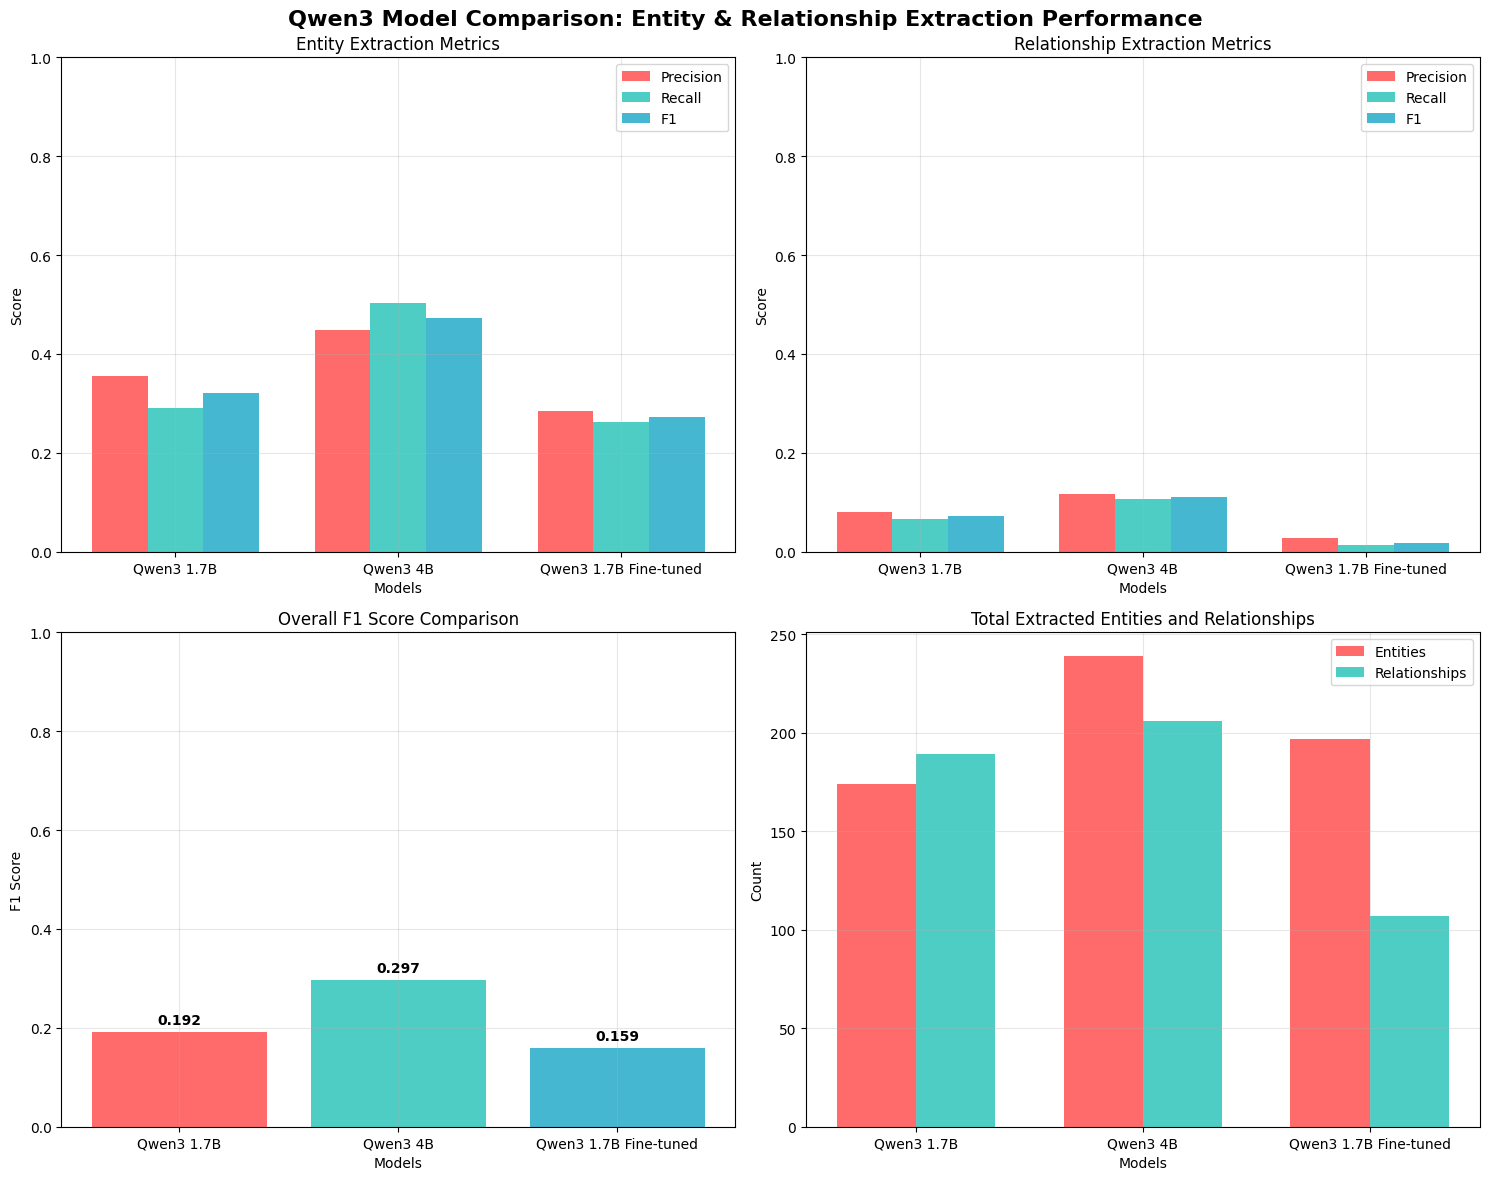

📊 Saved comparison plot to /content/drive/MyDrive/LLM_TKIG/data/notebooks/qwen3_comparison_2025-08-24_12-35-10.png


In [39]:
# Create comprehensive comparison visualizations
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Qwen3 Model Comparison: Entity & Relationship Extraction Performance', fontsize=16, fontweight='bold')

# Prepare data for plotting
models = [MODELS_CONFIG[key]['display_name'] for key in model_metrics.keys()]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 1. Entity Metrics Comparison
ax1 = axes[0, 0]
entity_metrics = ['entity_precision', 'entity_recall', 'entity_f1']
x = np.arange(len(models))
width = 0.25

for i, metric in enumerate(entity_metrics):
    values = [model_metrics[key][metric] for key in model_metrics.keys()]
    ax1.bar(x + i * width, values, width, label=metric.replace('entity_', '').title(), color=colors[i])

ax1.set_xlabel('Models')
ax1.set_ylabel('Score')
ax1.set_title('Entity Extraction Metrics')
ax1.set_xticks(x + width)
ax1.set_xticklabels(models)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# 2. Relationship Metrics Comparison
ax2 = axes[0, 1]
rel_metrics = ['relationship_precision', 'relationship_recall', 'relationship_f1']

for i, metric in enumerate(rel_metrics):
    values = [model_metrics[key][metric] for key in model_metrics.keys()]
    ax2.bar(x + i * width, values, width, label=metric.replace('relationship_', '').title(), color=colors[i])

ax2.set_xlabel('Models')
ax2.set_ylabel('Score')
ax2.set_title('Relationship Extraction Metrics')
ax2.set_xticks(x + width)
ax2.set_xticklabels(models)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# 3. Overall F1 Score Comparison
ax3 = axes[1, 0]
overall_f1_values = [model_metrics[key]['overall_f1'] for key in model_metrics.keys()]
bars3 = ax3.bar(models, overall_f1_values, color=colors[:len(models)])
ax3.set_xlabel('Models')
ax3.set_ylabel('F1 Score')
ax3.set_title('Overall F1 Score Comparison')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars3, overall_f1_values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Entity and Relationship Counts
ax4 = axes[1, 1]
entity_counts = [model_metrics[key]['test_entities_count'] for key in model_metrics.keys()]
rel_counts = [model_metrics[key]['test_relationships_count'] for key in model_metrics.keys()]

x = np.arange(len(models))
width = 0.35
ax4.bar(x - width/2, entity_counts, width, label='Entities', color=colors[0])
ax4.bar(x + width/2, rel_counts, width, label='Relationships', color=colors[1])

ax4.set_xlabel('Models')
ax4.set_ylabel('Count')
ax4.set_title('Total Extracted Entities and Relationships')
ax4.set_xticks(x)
ax4.set_xticklabels(models)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plot
plot_path = f"{BASE_PATH}data/notebooks/qwen3_comparison_{timestamp}.png"
fig.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"📊 Saved comparison plot to {plot_path}")


## 11. Detailed Metrics Summary Table


In [40]:
# Create a comprehensive metrics summary table
print("\n📋 Detailed Metrics Summary")
print("=" * 80)

# Prepare data for DataFrame
summary_data = []

# Add reference (Qwen3-14B) data as baseline
ref_entities = sum(result.get('entity_count', 0) for result in reference_subset)
ref_relationships = sum(result.get('relationship_count', 0) for result in reference_subset)

summary_data.append({
    'Model': 'Qwen3-14B (Reference)',
    'Entity Precision': 1.000,
    'Entity Recall': 1.000,
    'Entity F1': 1.000,
    'Relationship Precision': 1.000,
    'Relationship Recall': 1.000,
    'Relationship F1': 1.000,
    'Overall F1': 1.000,
    'Total Entities': ref_entities,
    'Total Relationships': ref_relationships,
    'Common Articles': len(reference_subset)
})

# Add test model results
for model_key, metrics in model_metrics.items():
    model_name = MODELS_CONFIG[model_key]['display_name']
    summary_data.append({
        'Model': model_name,
        'Entity Precision': metrics['entity_precision'],
        'Entity Recall': metrics['entity_recall'],
        'Entity F1': metrics['entity_f1'],
        'Relationship Precision': metrics['relationship_precision'],
        'Relationship Recall': metrics['relationship_recall'],
        'Relationship F1': metrics['relationship_f1'],
        'Overall F1': metrics['overall_f1'],
        'Total Entities': metrics['test_entities_count'],
        'Total Relationships': metrics['test_relationships_count'],
        'Common Articles': metrics['common_articles']
    })

# Create DataFrame and display
df_summary = pd.DataFrame(summary_data)
print(df_summary.round(3).to_string(index=False))

# Save summary table
csv_path = f"{BASE_PATH}data/notebooks/qwen3_metrics_summary_{timestamp}.csv"
df_summary.to_csv(csv_path, index=False)
print(f"\n💾 Saved metrics summary to {csv_path}")



📋 Detailed Metrics Summary
                Model  Entity Precision  Entity Recall  Entity F1  Relationship Precision  Relationship Recall  Relationship F1  Overall F1  Total Entities  Total Relationships  Common Articles
Qwen3-14B (Reference)             1.000          1.000      1.000                   1.000                1.000            1.000       1.000             266                  232               30
           Qwen3 1.7B             0.356          0.291      0.320                   0.079                0.067            0.073       0.192             174                  189               30
             Qwen3 4B             0.448          0.502      0.473                   0.117                0.107            0.112       0.297             239                  206               30
Qwen3 1.7B Fine-tuned             0.284          0.263      0.273                   0.028                0.013            0.018       0.159             197                  107               30

💾

## 12. Analysis and Insights


In [41]:
# Generate analysis insights
print("\n🔍 Analysis and Insights")
print("=" * 50)

# Find best performing model
if model_metrics:
    best_model_key = max(model_metrics.keys(), key=lambda k: model_metrics[k]['overall_f1'])
    best_model_name = MODELS_CONFIG[best_model_key]['display_name']
    best_f1 = model_metrics[best_model_key]['overall_f1']

    print(f"🏆 Best Overall Performance: {best_model_name} (F1: {best_f1:.3f})")

    # Performance analysis
    print("\n📊 Performance Analysis:")
    for model_key, metrics in model_metrics.items():
        model_name = MODELS_CONFIG[model_key]['display_name']
        print(f"\n{model_name}:")
        print(f"  • Entity extraction: {metrics['entity_f1']:.3f} F1 ({metrics['test_entities_count']} entities)")
        print(f"  • Relationship extraction: {metrics['relationship_f1']:.3f} F1 ({metrics['test_relationships_count']} relationships)")
        print(f"  • Overall performance: {metrics['overall_f1']:.3f} F1")

        # Performance relative to 14B
        relative_performance = metrics['overall_f1'] * 100
        print(f"  • Relative to 14B: {relative_performance:.1f}% performance")

    # Model size vs performance insights
    print("\n🎯 Key Insights:")
    print(f"• Tested {len(model_metrics)} models on {BATCH_SIZE} articles")
    print(f"• Reference baseline: Qwen3-14B with {ref_entities} entities and {ref_relationships} relationships")

    if len(model_metrics) >= 2:
        model_keys = list(model_metrics.keys())
        f1_diff = model_metrics[model_keys[1]]['overall_f1'] - model_metrics[model_keys[0]]['overall_f1']
        print(f"• Performance difference between 4B and 1.7B: {f1_diff:.3f} F1 points")

    print("\n💡 Recommendations:")
    if best_f1 > 0.7:
        print(f"• {best_model_name} shows strong performance for production use")
    elif best_f1 > 0.5:
        print(f"• {best_model_name} shows moderate performance, consider fine-tuning")
    else:
        print(f"• All models show low performance, significant improvements needed")

    print(f"• For resource-constrained environments, consider the trade-off between model size and performance")
    print(f"• Consider ensemble methods or fine-tuning to improve smaller model performance")
else:
    print("⚠️  No model results available for analysis")



🔍 Analysis and Insights
🏆 Best Overall Performance: Qwen3 4B (F1: 0.297)

📊 Performance Analysis:

Qwen3 1.7B:
  • Entity extraction: 0.320 F1 (174 entities)
  • Relationship extraction: 0.073 F1 (189 relationships)
  • Overall performance: 0.192 F1
  • Relative to 14B: 19.2% performance

Qwen3 4B:
  • Entity extraction: 0.473 F1 (239 entities)
  • Relationship extraction: 0.112 F1 (206 relationships)
  • Overall performance: 0.297 F1
  • Relative to 14B: 29.7% performance

Qwen3 1.7B Fine-tuned:
  • Entity extraction: 0.273 F1 (197 entities)
  • Relationship extraction: 0.018 F1 (107 relationships)
  • Overall performance: 0.159 F1
  • Relative to 14B: 15.9% performance

🎯 Key Insights:
• Tested 3 models on 30 articles
• Reference baseline: Qwen3-14B with 266 entities and 232 relationships
• Performance difference between 4B and 1.7B: 0.105 F1 points

💡 Recommendations:
• All models show low performance, significant improvements needed
• For resource-constrained environments, conside

## 13. Save Complete Results


In [42]:
# Save complete comparison results
if model_metrics:
    best_model_key = max(model_metrics.keys(), key=lambda k: model_metrics[k]['overall_f1'])
    best_model_name = MODELS_CONFIG[best_model_key]['display_name']
    best_f1 = model_metrics[best_model_key]['overall_f1']
else:
    best_model_name = "None"
    best_f1 = 0.0

comparison_results = {
    'timestamp': timestamp,
    'configuration': {
        'batch_size': BATCH_SIZE,
        'start_index': START_INDEX,
        'models_tested': list(MODELS_CONFIG.keys()),
        'reference_file': reference_path,
        'data_file': data_path
    },
    'metrics': model_metrics,
    'summary': {
        'best_model': best_model_name,
        'best_f1': best_f1,
        'total_articles_processed': len(reference_subset) if reference_subset else 0,
        'reference_entities': ref_entities if 'ref_entities' in locals() else 0,
        'reference_relationships': ref_relationships if 'ref_relationships' in locals() else 0
    }
}

# Save complete results
results_path = f"{BASE_PATH}data/entity-extraction/qwen3_comparison_results_{timestamp}.json"
with open(results_path, 'w', encoding='utf-8') as f:
    json.dump(comparison_results, f, ensure_ascii=False, indent=2)

print(f"💾 Saved complete comparison results to {results_path}")
print(f"\n✅ Model comparison completed successfully!")
print(f"📊 Summary: {len(model_metrics)} models tested on {BATCH_SIZE} articles")
print(f"🏆 Best performer: {best_model_name} with {best_f1:.3f} F1 score")


💾 Saved complete comparison results to /content/drive/MyDrive/LLM_TKIG/data/entity-extraction/qwen3_comparison_results_2025-08-24_12-35-10.json

✅ Model comparison completed successfully!
📊 Summary: 3 models tested on 30 articles
🏆 Best performer: Qwen3 4B with 0.297 F1 score
